# **1. Introdução**

## **1.1 Carregando o pyspark**

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName("Avaliação do modelo - Teste Estatistico").getOrCreate()

In [2]:
spark

## **1.2 Carregando as principais funções**

In [4]:
import os

# Exibir o caminho do diretório atual
print("Caminho do diretório atual:", os.getcwd())

Caminho do diretório atual: /home/jovyan/work


In [5]:
import poetry
print(poetry.__version__)


ModuleNotFoundError: No module named 'poetry'

In [3]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
import pandas as pd
from datetime import datetime
import sys
import os

# Adiciona a pasta work ao sys.path
sys.path.append('/home/jovyan/')

from work.src.utils import *
start_time = datetime.now()


n = 'best_lr_model'
caminho_modelo = 'work/models'

ModuleNotFoundError: No module named 'scipy'

In [4]:
n_bootstrap = 5

## **2.3 Métricas BASE DE VALIDAÇÃO**

<font size=2>**Documentação:**</font>
<font size=2>[LogisticRegressionTrainingSummary](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegressionTrainingSummary.html)</font>

In [5]:
predictions_val = spark.read.orc(f'work/data/final/predictions_val_{n}.orc')

In [6]:
# predictions_val.show(truncate=False)
# +-----------------------------------------------------------------------------------------------------------+-----+------------------------------------------+----------------------------------------+----------+
# |features                                                                                                   |label|rawPrediction                             |probability                             |prediction|
# +-----------------------------------------------------------------------------------------------------------+-----+------------------------------------------+----------------------------------------+----------+
# |(24,[1,2,5,6,10,11,12,13,14,18,23],[12.0,75.85,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                       |0    |[0.05103567311346513,-0.05103567311346513]|[0.5127561496338285,0.48724385036617146]|0.0       |
# |(24,[1,2,3,5,8,12,13,14,19,21],[69.0,61.45,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                               |0    |[2.382789551862372,-2.382789551862372]    |[0.9155054708840569,0.08449452911594313]|0.0       |
# |(24,[1,2,3,5,12,13,15,17,22],[46.0,80.8824189403559,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                          |1    |[-1.1704365714764247,1.1704365714764247]  |[0.23677608099237907,0.7632239190076209]|1.0       |

In [7]:
print('METRICAS RESUMO DA BASE DE VALIDAÇÃO')

auc_roc = calculate_auc_roc(predictions_val)
print(f"AUC ROC: {auc_roc}")
auc_pr = calculate_auc_pr(predictions_val)
print(f"AUC PR: {auc_pr}")
ks = calculate_ks(predictions_val)
print(f"KS: {ks}")

METRICAS RESUMO DA BASE DE VALIDAÇÃO
AUC ROC: 0.7897105323794532
AUC PR: 0.7617664882695159
KS: 0.5794210647589065


In [8]:
calculate_confusion_matrix(predictions_val)

{'TP': 870, 'TN': 774, 'FP': 235, 'FN': 201}

In [9]:
calcula_mostra_matriz_confusao(predictions_val, normalize=False)

                     Previsto
                Churn       Não-Churn
     Churn        870         201
Real
     Não-Churn    235         774


## **2.4 Métricas BASE DE TESTE**

In [10]:
predictions_test = spark.read.orc(f'work/data/final/predictions_test_{n}.orc')

In [11]:
print('METRICAS RESUMO DA BASE DE TESTE')

auc_roc = calculate_auc_roc(predictions_test)
print(f"AUC ROC: {auc_roc}")
auc_pr = calculate_auc_pr(predictions_test)
print(f"AUC PR: {auc_pr}")
ks = calculate_ks(predictions_test)
print(f"KS: {ks}")

METRICAS RESUMO DA BASE DE TESTE
AUC ROC: 0.7630023396167441
AUC PR: 0.7168174012626157
KS: 0.5260046792334883


In [12]:
calculate_confusion_matrix(predictions_test)

{'TP': 830, 'TN': 761, 'FP': 290, 'FN': 205}

In [13]:
calcula_mostra_matriz_confusao(predictions_test, normalize=False)

                     Previsto
                Churn       Não-Churn
     Churn        830         205
Real
     Não-Churn    290         761


# **3. Boostramp, intervalos de confiança, Permutacion test**

## **3.1 Boostramp - VALIDAÇÃO**

In [14]:
predictions_val.count()

2080

In [15]:
# Calcule intervalos de confiança e média
scores, resultados = bootstrap_metric_spark(
    data = predictions_val, 
    n_bootstrap = n_bootstrap,
    confidence_level = 0.95
    )

Será realizada 5 iterações
Execução iteração: 0
Sample count: 2129
---------------
Execução iteração: 1
Sample count: 2060
---------------
Execução iteração: 2
Sample count: 2062
---------------
Execução iteração: 3
Sample count: 2069
---------------
Execução iteração: 4
Sample count: 2091
---------------


In [16]:
pd.DataFrame(resultados).T
#   NESTE TESTE NÃO UTILIZO O TESTE T

,confidence_interval,mean_score,std_dev
ks,"[0.5587163142695343, 0.5940801326675024]",0.579402,0.014293
auc,"[0.7793581571347672, 0.7970400663337511]",0.789701,0.007146
auc_pr,"[0.7587768523408239, 0.7755809192338347]",0.765438,0.007362


In [17]:
scores_df = df_scores(scores)
scores_df

# ks.scores	auc.scores	auc_pr.scores
# 0	0.583983	0.791992	0.769682
# 1	0.576596	0.788298	0.758596
# 2	0.556730	0.778365	0.762273
# 3	0.595138	0.797569	0.776236
# 4	0.584564	0.792282	0.760402

,ks.scores,auc.scores,auc_pr.scores
0,0.583983,0.791992,0.769682
1,0.576596,0.788298,0.758596
2,0.556730,0.778365,0.762273
3,0.595138,0.797569,0.776236
4,0.584564,0.792282,0.760402


## **3.2 Boostramp e Permutacion test**

* BASE: VALIDAÇÃO
* BASE: TESTE

In [18]:
print(predictions_val.count())
print(predictions_test.count())
# 2080
# 2086

2080
2086


Iteração 1/5
Sample1 count: 2129
Sample2 count: 2136
----------
Iteração 2/5
Sample1 count: 2060
Sample2 count: 2066
----------
Iteração 3/5
Sample1 count: 2062
Sample2 count: 2066
----------
Iteração 4/5
Sample1 count: 2069
Sample2 count: 2075
----------
Iteração 5/5
Sample1 count: 2091
Sample2 count: 2095
----------
########################################
ks
* Intervalo do bin: 0.009


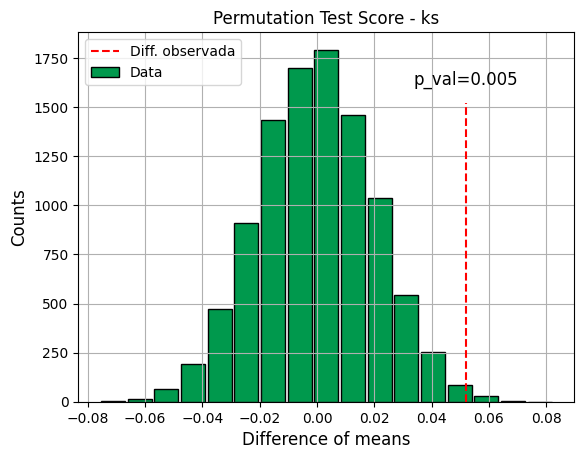


 Teste de Significancia 
**$H_0$:** Diferença entre as médias das métricas é zero. 

 Arrays sizes: 5, 5 
* Difference between averages: 0.5794 - 0.5276 = 0.0518
* p_val = 0.0049 
The model seems to produce different results with CI-0.95 (reject H0).

########################################
auc
* Intervalo do bin: 0.005


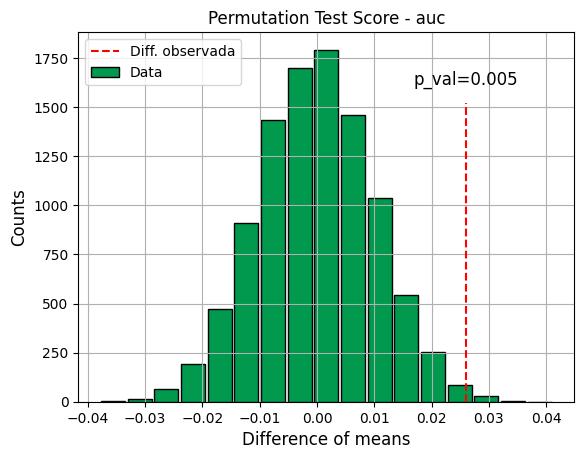


 Teste de Significancia 
**$H_0$:** Diferença entre as médias das métricas é zero. 

 Arrays sizes: 5, 5 
* Difference between averages: 0.7897 - 0.7638 = 0.0259
* p_val = 0.0049 
The model seems to produce different results with CI-0.95 (reject H0).

########################################
auc_pr
* Intervalo do bin: 0.007


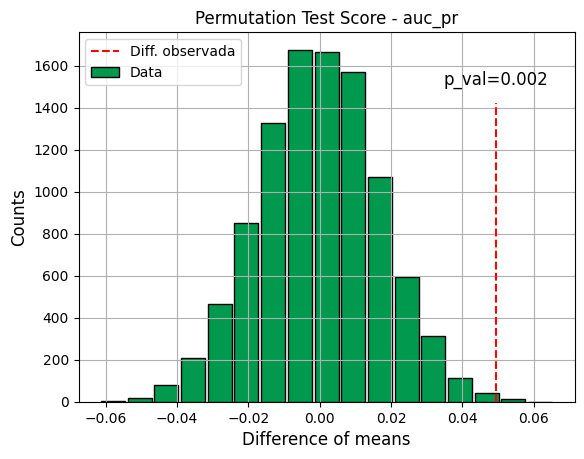


 Teste de Significancia 
**$H_0$:** Diferença entre as médias das métricas é zero. 

 Arrays sizes: 5, 5 
* Difference between averages: 0.7654 - 0.7160 = 0.0494
* p_val = 0.0018 
The model seems to produce different results with CI-0.95 (reject H0).



In [19]:
scores_results_permutacion, intervarlos_results = bootstrap_metric_spark_permutacion(
    data1 = predictions_val, 
    data2 = predictions_test, 
    n_bootstrap = n_bootstrap,
    confidence_level = 0.95
    )

In [20]:
pd.DataFrame(intervarlos_results).T
# ESSE COMENTÁRIO NÃO UTILIZA O TESTE T
# 	confidence_interval1	mean_score1	std_dev1	confidence_interval2	mean_score2	std_dev2
# ks	[0.5587163142695343, 0.5940801326675024]	0.579402	0.014293	[0.4926559689045311, 0.5510315509616689]	0.527572	0.02525
# auc	[0.7793581571347672, 0.7970400663337511]	0.789701	0.007146	[0.7463279844522657, 0.7755157754808344]	0.763786	0.012625
# auc_pr	[0.7587768523408239, 0.7755809192338347]	0.765438	0.007362	[0.6988262164456484, 0.7300824389636984]	0.716001	0.01349

,confidence_interval1,mean_score1,std_dev1,confidence_interval2,mean_score2,std_dev2
ks,"[0.5616550469597459, 0.5971489814132092]",0.579402,0.014293,"[0.4962198465647983, 0.5589234802400616]",0.527572,0.02525
auc,"[0.7808275234798729, 0.7985744907066044]",0.789701,0.007146,"[0.7481099232823993, 0.7794617401200308]",0.763786,0.012625
auc_pr,"[0.7562967286806118, 0.7745793430370161]",0.765438,0.007362,"[0.699250927290684, 0.7327510841361179]",0.716001,0.01349


In [21]:
df_scores_result = df_scores_1_2(scores_results_permutacion)
df_scores_result


KS p_value': 0.0049
KS mean_diff': 0.05183035078404763
auc p_value: 0.0049
auc mean_diff: 0.025915175392023593
auc_pr p_value: 0.0018
auc_pr mean_diff: 0.04943703014541301


,ks.scores1,ks.scores2,auc.scores1,auc.scores2,auc_pr.scores1,auc_pr.scores2
0,0.583983,0.490242,0.791992,0.745121,0.769682,0.706142
1,0.576596,0.551584,0.788298,0.775792,0.758596,0.723848
2,0.556730,0.514383,0.778365,0.757191,0.762273,0.721227
3,0.595138,0.535587,0.797569,0.767793,0.776236,0.730775
4,0.584564,0.546064,0.792282,0.773032,0.760402,0.698013


# **4. Tempo de execução**

In [22]:
end_time = datetime.now()
execution_time = end_time - start_time

print(f"Tempo de execução: {execution_time}")


Tempo de execução: 0:01:00.579998
